<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup-&amp;-Summary" data-toc-modified-id="Setup-&amp;-Summary-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup &amp; Summary</a></span><ul class="toc-item"><li><span><a href="#Workflow" data-toc-modified-id="Workflow-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Workflow</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Reference</a></span></li><li><span><a href="#Setup-my-kaggle-API" data-toc-modified-id="Setup-my-kaggle-API-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Setup my kaggle API</a></span></li></ul></li><li><span><a href="#Facial-Keypoints-Detection-with-PyTorch" data-toc-modified-id="Facial-Keypoints-Detection-with-PyTorch-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Facial Keypoints Detection with PyTorch</a></span></li><li><span><a href="#Explore-Data" data-toc-modified-id="Explore-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Explore Data</a></span><ul class="toc-item"><li><span><a href="#Missing-values" data-toc-modified-id="Missing-values-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Missing values</a></span></li><li><span><a href="#Test-data" data-toc-modified-id="Test-data-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Test data</a></span></li><li><span><a href="#Base-case:-drop-missing-data" data-toc-modified-id="Base-case:-drop-missing-data-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Base case: drop missing data</a></span></li></ul></li><li><span><a href="#Preprocessing-Data" data-toc-modified-id="Preprocessing-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Preprocessing Data</a></span><ul class="toc-item"><li><span><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Data Augmentation</a></span></li><li><span><a href="#Prepared-loaders-with-augmentation" data-toc-modified-id="Prepared-loaders-with-augmentation-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Prepared loaders with augmentation</a></span></li><li><span><a href="#Create-FaceKeypointsDataset" data-toc-modified-id="Create-FaceKeypointsDataset-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Create FaceKeypointsDataset</a></span></li></ul></li><li><span><a href="#Convolutional-Neural-Network-(CNN)" data-toc-modified-id="Convolutional-Neural-Network-(CNN)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Convolutional Neural Network (CNN)</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Train</a></span></li><li><span><a href="#View-Predictions" data-toc-modified-id="View-Predictions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>View Predictions</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Evaluation</a></span></li><li><span><a href="#2-Models-2-Datasets" data-toc-modified-id="2-Models-2-Datasets-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>2 Models-2 Datasets</a></span><ul class="toc-item"><li><span><a href="#L-Model" data-toc-modified-id="L-Model-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>L Model</a></span></li><li><span><a href="#S-Model" data-toc-modified-id="S-Model-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>S Model</a></span></li><li><span><a href="#Combine-L-&amp;-S-model-predictions" data-toc-modified-id="Combine-L-&amp;-S-model-predictions-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>Combine L &amp; S model predictions</a></span></li></ul></li></ul></div>

# Setup & Summary

## Workflow
- CNN
- Augmentation
- 2 models for L/S datasets (missing value)

## Reference
Some functions and ideas are from this blog to help us get familiar with this dataset and competition:
    - https://medium.com/diving-in-deep/facial-keypoints-detection-with-pytorch-86bac79141e4

## Setup my kaggle API

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['KAGGLE_USERNAME'] = "xxx"
os.environ['KAGGLE_KEY'] = "xxx"

# Facial Keypoints Detection with PyTorch

Detecting key positions on face image is useful in several applications such as tracking face in image or video, analyzing facial expression, face recognition, and so on. We will use data provided by [Kaggle's Facial Keypoints Detection competition](https://www.kaggle.com/c/facial-keypoints-detection) and evaluate our predictions through it.

Download data from Kaggle

In [1]:
# # Install Kaggle API
# !conda install -q kaggle



 Set Kaggle username and key (see your kaggle.json).

In [2]:
# # fill in xxxx, see your kaggle.json
# import os
# os.environ['KAGGLE_USERNAME'] = "xxx"
# os.environ['KAGGLE_KEY'] = "xxx"

# # download data from Kaggle
# !kaggle competitions download -c facial-keypoints-detection -p data

Unzip the training and test datasets into data directory. 

In [3]:
# # Unzip datasets to data directory
# !unzip data/facial-keypoints-detection.zip -d data

In [4]:
# # Unzip training and test datasets to data directory
# !unzip data/training.zip -d data
# !unzip data/test.zip -d data

# Explore Data

Download required dependencies.

In [7]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils

from torch import nn, optim
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore')

IMG_SIZE = 96

In [8]:
data_dir = Path('./data')
train_data = pd.read_csv(data_dir / 'training.csv')

There are 7,049 images in training data. The input image, in the last field of data, consists of pixels as integers in (0-255).  The images are 96x96 pixels. The labels or targets are cordinates (x, y) of 15 keypoints:

*   Eyes: left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner
*   Eyebrows: left_eyebrow_inner, left_eyebrow_outer, right_eyebrow_inner, right_eyebrow_outer
*   Nose and Mouth: nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top, mouth_center_bottom.

As you can see, there are missing labels in train data.  There are only 2,140 images with all 15 keypoints .   We will consider how to work with them later.

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [11]:
# functions to show image and keypoints
def show_keypoints(image, keypoints):
    '''
    Show image with keypoints
    Args:
        image (array-like or PIL image): The image data. (M, N)
        keypoints (array-like): The keypoits data. (N, 2)
    '''
      
    plt.imshow(image, cmap='gray')
    if len(keypoints):
        plt.scatter(keypoints[:, 0], keypoints[:, 1], s=24, marker ='.', c='r')

In [12]:
def show_images(df, indxs, ncols=5, figsize=(15,10), with_keypoints=True):
    '''
    Show images with keypoints in grids
    Args:
        df (DataFrame): data (M x N)
        idxs (iterators): list, Range, Indexes
        ncols (integer): number of columns (images by rows)
        figsize (float, float): width, height in inches
        with_keypoints (boolean): True if show image with keypoints
    '''
    plt.figure(figsize=figsize)
    nrows = len(indxs) // ncols + 1
    for i, idx in enumerate(indxs):
        image = np.fromstring(df.loc[idx, 'Image'], sep=' ').astype(np.float32).reshape(-1, IMG_SIZE)
        if with_keypoints:
            keypoints = df.loc[idx].drop('Image').values.astype(np.float32).reshape(-1, 2)
        else:
            keypoints = []
        plt.subplot(nrows, ncols, i + 1)
        plt.title(f'Sample #{idx}')
        plt.axis('off')
        plt.tight_layout()
        show_keypoints(image, keypoints)
    plt.show()

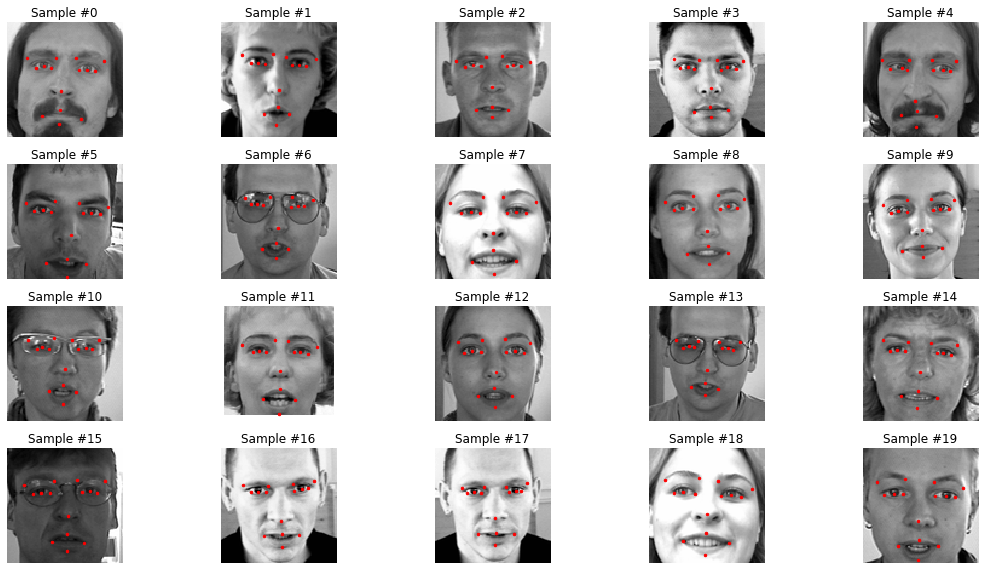

In [13]:
# View train images
show_images(train_data, range(20))

## Missing values

In [ ]:
# Explore missing-any-data

missing_any_data = train_data[train_data.isnull().any(axis=1)]

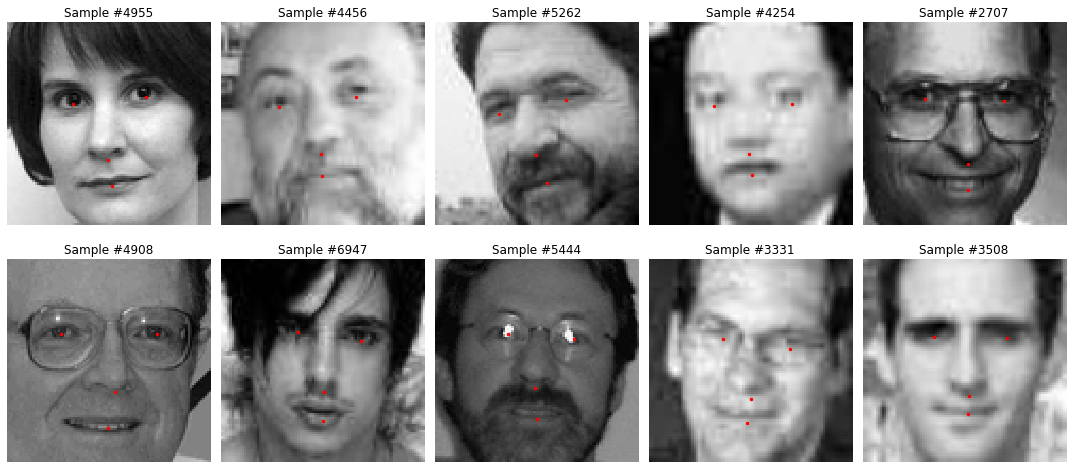

In [15]:
# View random missing-any-data images
idxs = missing_any_data.index
idxs = np.random.choice(idxs, 10)
show_images(train_data, idxs)

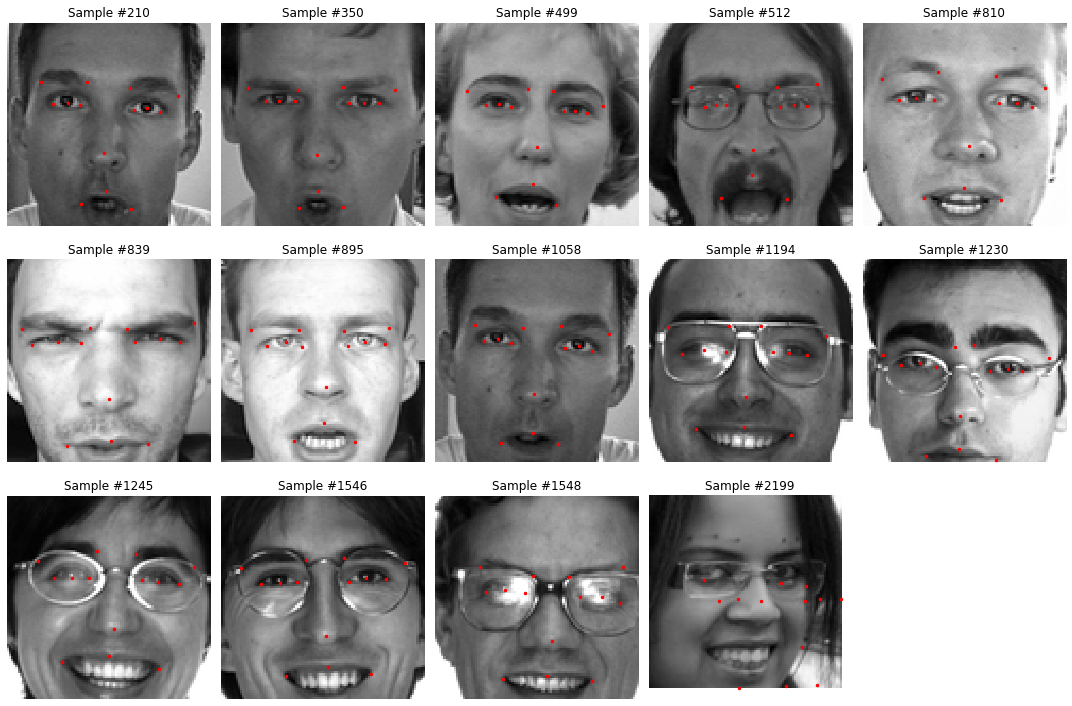

In [17]:
# Explore missing-bottom-lip-only data
missing_bottom_lip_only = train_data[(train_data.mouth_center_bottom_lip_x.isnull(
) & train_data.mouth_center_top_lip_x.notnull())]

# View missing-bottom-lip-only images
idxs = missing_bottom_lip_only.index
show_images(train_data, idxs)

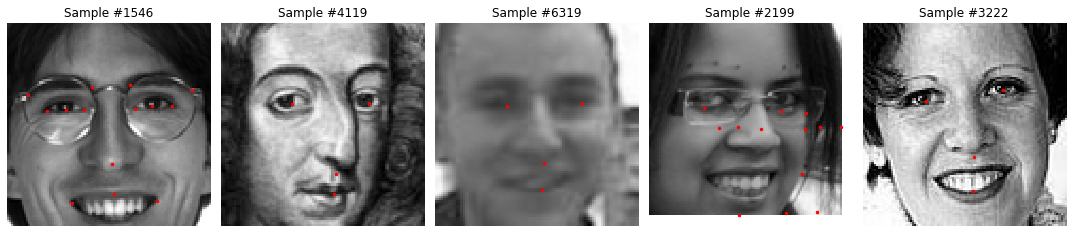

In [18]:
show_images(train_data, [1546, 4119, 6319, 2199, 3222])

Besides missing-keypoint, there are blur, cropped, and even missed-annotated sample. If we want to use these samples, we need to decide how to handle missing data.

## Test data

For test data, there're 1,783 images with only two field-ImageId and Image.

In [19]:
test_data = pd.read_csv(data_dir / 'test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1783 entries, 0 to 1782
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ImageId  1783 non-null   int64 
 1   Image    1783 non-null   object
dtypes: int64(1), object(1)
memory usage: 28.0+ KB


In [20]:
test_data.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


## Base case: drop missing data

We will begin with the samples having all 15 keypoints as base case. There're 2,140 samples having all keypoints in training data. We will use this dataset as our base case.

In [21]:
train_df = train_data.dropna()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140 entries, 0 to 2283
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          2140 non-null   float64
 1   left_eye_center_y          2140 non-null   float64
 2   right_eye_center_x         2140 non-null   float64
 3   right_eye_center_y         2140 non-null   float64
 4   left_eye_inner_corner_x    2140 non-null   float64
 5   left_eye_inner_corner_y    2140 non-null   float64
 6   left_eye_outer_corner_x    2140 non-null   float64
 7   left_eye_outer_corner_y    2140 non-null   float64
 8   right_eye_inner_corner_x   2140 non-null   float64
 9   right_eye_inner_corner_y   2140 non-null   float64
 10  right_eye_outer_corner_x   2140 non-null   float64
 11  right_eye_outer_corner_y   2140 non-null   float64
 12  left_eyebrow_inner_end_x   2140 non-null   float64
 13  left_eyebrow_inner_end_y   2140 non-null   float

# Preprocessing Data

One important process in data science pipeline is data preprocessing. PyTorch provides `Dataset` and `DataLoader` classes to make it easy and, hopefully, to make your code more readable.

## Data Augmentation
- HorizontalFlip is used here

In [40]:
class RandomHorizontalFlip(object):
    '''
    Horizontally flip image randomly with given probability
    Args:
        p (float): probability of the image being flipped.
                   Defalut value = 0.5
    '''
    
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        
        flip_indices = [(0, 2), (1, 3),
                        (4, 8), (5, 9), (6, 10), (7, 11),
                        (12, 16), (13, 17), (14, 18), (15, 19),
                        (22, 24), (23, 25)]
        
        image, keypoints = sample['image'], sample['keypoints']
        
        if np.random.random() < self.p:
            image = image[:, ::-1]
            if keypoints is not None:
                for a, b in flip_indices:
                    keypoints[a], keypoints[b]= keypoints[b], keypoints[a]
                keypoints[::2] = 96. - keypoints[::2]
        
        return {'image': image, 
                'keypoints': keypoints}

 Let's see what augmented images look like.

In [ ]:
aug_train_df = train_data.dropna()
aug_transform = transforms.Compose([RandomHorizontalFlip(p=1.0), 
                                    Normalize(),
                                    ToTensor()])
aug_trainset = FaceKeypointsDataset(aug_train_df, transform=aug_transform)

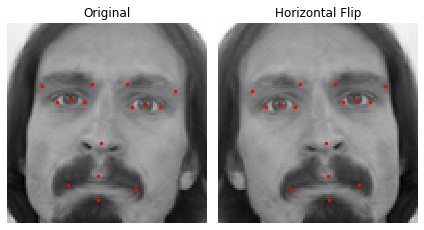

In [42]:
plt.subplot(1,2,1)
plt.title(f'Original')
plt.axis('off')
plt.tight_layout()
image = trainset[0]['image'].numpy().squeeze()
keypoints = trainset[0]['keypoints'].numpy().reshape(-1,2)
show_keypoints(image, keypoints)
plt.subplot(1,2,2)
plt.title(f'Horizontal Flip')
plt.axis('off')
plt.tight_layout()
image = aug_trainset[0]['image'].numpy().squeeze()
keypoints = aug_trainset[0]['keypoints'].numpy().reshape(-1,2)
show_keypoints(image, keypoints)

## Prepared loaders with augmentation

In [46]:
# how many samples per batch to load
batch_size = 128
# percentage of training set to use as validation
valid_size = 0.2


# Drop missing data
aug_train_df = train_data.dropna()

# Define a transform to augment the data
aug_tfms = transforms.Compose([RandomHorizontalFlip(p=0.5),
                                    Normalize(),
                                    ToTensor()])

# Load the training data
aug_trainset = FaceKeypointsDataset(aug_train_df, transform=aug_tfms)


# prepare data loaders
aug_train_loader, aug_valid_loader = prepare_train_valid_loaders(aug_trainset, 
                                                                 valid_size,
                                                                 batch_size)

## Create FaceKeypointsDataset

Sample of our dataset will be a `dict {'image': image, 'keypoints': keypoints}`. Our dataset will take an optional argument `transform` so that any required processing can be applied on the sample.

In [22]:
class FaceKeypointsDataset(Dataset):
    '''Face Keypoints Dataset'''
    
    def __init__(self, dataframe, train=True, transform=None):
        '''
        Args:
            dataframe (DataFrame): data in pandas dataframe format.
            train (Boolean) : True for train data with keypoints, default is True
            transform (callable, optional): Optional transform to be applied on 
            sample
        '''
        self.dataframe = dataframe
        self.train = train
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = np.fromstring(self.dataframe.iloc[idx, -1], sep=' ')\
                .astype(np.float32).reshape(-1, IMG_SIZE)
        
        if self.train:
            keypoints = self.dataframe.iloc[idx, :-1].values.astype(np.float32)
        else:
            keypoints = None

        sample = {'image': image, 'keypoints': keypoints}
        
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

Before feeding into the model, numpy-array images need to be normalized and converted to Tensor. We will create transform as callable classes named Normalize and ToTensor.

In [23]:
class Normalize(object):
    '''Normalize input images'''
    
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']
        
        return {'image': image / 255., # scale to [0, 1]
                'keypoints': keypoints}
        
class ToTensor(object):
    '''Convert ndarrays in sample to Tensors.'''

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.reshape(1, IMG_SIZE, IMG_SIZE)
        image = torch.from_numpy(image)
        
        if keypoints is not None:
            keypoints = torch.from_numpy(keypoints)
            return {'image': image, 'keypoints': keypoints}
        else:
            return {'image': image}

In [24]:
# train-val split
from torch.utils.data.sampler import SubsetRandomSampler

def prepare_train_valid_loaders(trainset, valid_size=0.2, 
                                batch_size=128):
    '''
    Split trainset data and prepare DataLoader for training and validation
    
    Args:
        trainset (Dataset): data 
        valid_size (float): validation size, defalut=0.2
        batch_size (int) : batch size, default=128
    ''' 
    
    # obtain training indices that will be used for validation
    num_train = len(trainset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # prepare data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               sampler=valid_sampler)
    
    return train_loader, valid_loader

In [25]:
# drop any-missing-keypoint records
train_df = train_data.dropna()
test_df = test_data
testset = FaceKeypointsDataset(test_df, train=False, transform=tsfm)

test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

In [46]:
# how many samples per batch to load
batch_size = 128
# percentage of training set to use as validation
valid_size = 0.2


# Drop missing data
aug_train_df = train_data.dropna()

# Define a transform to augment the data
aug_tfms = transforms.Compose([RandomHorizontalFlip(p=0.5),
                                    Normalize(),
                                    ToTensor()])

# Load the training data
aug_trainset = FaceKeypointsDataset(aug_train_df, transform=aug_tfms)


# prepare data loaders
aug_train_loader, aug_valid_loader = prepare_train_valid_loaders(aug_trainset, 
                                                                 valid_size,
                                                                 batch_size)

# Convolutional Neural Network (CNN)

A 3-layer CNN is built as the basline model and trained from scratch

In [53]:
class CNN(nn.Module):
    '''
    Convolutional Neural Network model
            
    Args:
        ---------
        output_size (integer): size of the output layer
    '''
    
    def __init__(self, outputs=30):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*12*12, 1024)
        self.fc2 = nn.Linear(1024, outputs)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(self.dropout(x)))
        x = self.fc2(self.dropout(x))
        
        return x

# Train

In [30]:
def train(train_loader, valid_loader, model, criterion, optimizer, 
          n_epochs=50, saved_model='model.pt'):
    '''
    Train the model
    
    Args:
        train_loader (DataLoader): DataLoader for train Dataset
        valid_loader (DataLoader): DataLoader for valid Dataset
        model (nn.Module): model to be trained on
        criterion (torch.nn): loss funtion
        optimizer (torch.optim): optimization algorithms
        n_epochs (int): number of epochs to train the model
        saved_model (str): file path for saving model
    
    Return:
        tuple of train_losses, valid_losses
    '''

    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf # set initial "min" to infinity

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*batch['image'].size(0)

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for batch in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device))
            # calculate the loss
            loss = criterion(output, batch['keypoints'].to(device))
            # update running validation loss 
            valid_loss += loss.item()*batch['image'].size(0)

        # print training/validation statistics 
        # calculate average Root Mean Square loss over an epoch
        train_loss = np.sqrt(train_loss/len(train_loader.sampler.indices))
        valid_loss = np.sqrt(valid_loss/len(valid_loader.sampler.indices))

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'
              .format(epoch+1, train_loss, valid_loss))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), saved_model)
            valid_loss_min = valid_loss
            
    return train_losses, valid_losses  

Now let's train CNN model with augmented data.

In [54]:
model = CNN(outputs=30)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [55]:
aug_cnn_train_losses, aug_cnn_valid_losses = train(aug_train_loader, aug_valid_loader, model, criterion, 
                                                   optimizer, n_epochs=50, saved_model='aug_cnn.pt')

Epoch: 1 	Training Loss: 37.539205 	Validation Loss: 25.234221
Validation loss decreased (inf --> 25.234221).  Saving model ...
Epoch: 2 	Training Loss: 17.513749 	Validation Loss: 12.118404
Validation loss decreased (25.234221 --> 12.118404).  Saving model ...
Epoch: 3 	Training Loss: 9.704698 	Validation Loss: 7.414173
Validation loss decreased (12.118404 --> 7.414173).  Saving model ...
Epoch: 4 	Training Loss: 6.202123 	Validation Loss: 4.507438
Validation loss decreased (7.414173 --> 4.507438).  Saving model ...
Epoch: 5 	Training Loss: 4.909338 	Validation Loss: 3.859673
Validation loss decreased (4.507438 --> 3.859673).  Saving model ...
Epoch: 6 	Training Loss: 4.513849 	Validation Loss: 3.556884
Validation loss decreased (3.859673 --> 3.556884).  Saving model ...
Epoch: 7 	Training Loss: 4.365609 	Validation Loss: 3.515500
Validation loss decreased (3.556884 --> 3.515500).  Saving model ...
Epoch: 8 	Training Loss: 4.313835 	Validation Loss: 3.398925
Validation loss decreased 

# View Predictions

In [34]:
def predict(data_loader, model):
    '''
    Predict keypoints
    Args:
        data_loader (DataLoader): DataLoader for Dataset
        model (nn.Module): trained model for prediction.
    Return:
        predictions (array-like): keypoints in float (no. of images x keypoints).
    '''
    
    model.eval() # prep model for evaluation

    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(batch['image'].to(device)).cpu().numpy()
            if i == 0:
                predictions = output
            else:
                predictions = np.vstack((predictions, output))
    
    return predictions

In [35]:
def view_pred_df(columns, test_df, predictions, image_ids=range(1,6)):
    '''
    Display predicted keypoints
    Args:
        columns (array-like): column names
        test_df (DataFrame): dataframe with ImageId and Image columns
        predictions (array-like): keypoints in float (no. of images x keypoints)
        image_id (array-like): list or range of ImageIds begin at 1
    '''
    pred_df = pd.DataFrame(predictions, columns=columns)
    pred_df = pd.concat([pred_df, test_df], axis=1)
    pred_df = pred_df.set_index('ImageId')
    show_images(pred_df, image_ids)  # ImageId as index begin at 1

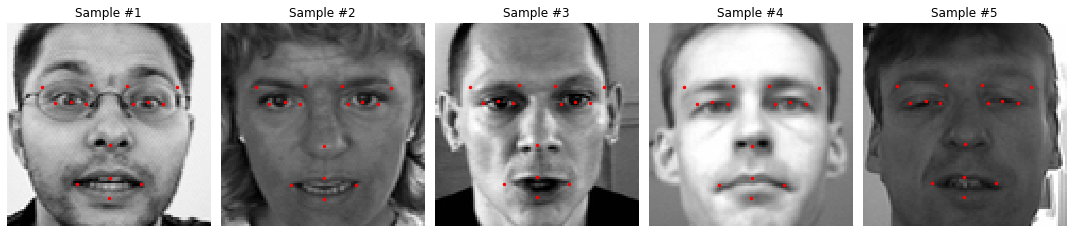

In [57]:
model.load_state_dict(torch.load('aug_cnn.pt'))

predictions = predict(test_loader, model)

create_submission(predictions, 
                  pred_file='data/aug_cnn_preds.csv', 
                  sub_file='data/aug_cnn_submission.csv')

view_pred_df(columns, test_df, predictions)

# Evaluation
    We will first create a csv file of prediction and then submit it to Kaggle

In [37]:
def create_submission(predictions, pred_file='data/preds.csv', sub_file='data/submission.csv', columns=None):
    '''
    Create csv file for submission from predictions
    Args:
        predictions (array-like): prediction (no. fo images x 30 keypoints)
        pred_file (string): file path for prediction csv file
        sub_file (string): file path for submission csv file
        columns (dict): provided column names for submission file
    '''
    lookup = pd.read_csv('data/IdLookupTable.csv')
    if columns == None:
        columns = train_data.columns[:-1]
    preds = pd.DataFrame(predictions, 
                         index=np.arange(1, len(predictions)+1), 
                         columns=columns)
    preds.to_csv(pred_file)
    locations = [preds.loc[image_id, feature_name] 
                 for image_id, feature_name 
                 in lookup[['ImageId', 'FeatureName']].values]
    locations = [location if location < IMG_SIZE else IMG_SIZE for location in locations]
    lookup.Location = pd.Series(locations)
    lookup[['RowId', 'Location']].to_csv(sub_file, index=False)

In [37]:
create_submission(predictions)

In [83]:
# Comment out to submit to Kaggle: 
# !kaggle competitions submit -c facial-keypoints-detection -f data/aug_cnn_submission.csv -m "Augmented CNN"

100%|█████████████████████████████████████████| 629k/629k [00:01<00:00, 397kB/s]
Successfully submitted to Facial Keypoints Detection

# 2 Models-2 Datasets

So far we just use 2,140 images from total 7,094 images in original training data. After more data exploration, we found there're two groups of keypoints-one with about 2,000 samples (15 keypoints) and one with about 7,000 samples (4 keypoints). To make uses of them, we will build separate models based on samples of each groups.

We will group samples into two groups, L (Large)-for the keypoints with about 7,000 samples and S (Small)-for the keypoints with about 2,000 samples. We will define this in datasets dictionary.

In [60]:
datasets = {'L': ['left_eye_center_x', 'left_eye_center_y',
                  'right_eye_center_x','right_eye_center_y',
                  'nose_tip_x', 'nose_tip_y',
                  'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y',
                  'Image'
                 ], 
            'S': ['left_eye_inner_corner_x','left_eye_inner_corner_y', 
                  'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 
                  'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 
                  'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 
                  'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 
                  'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 
                  'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 
                  'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y',
                  'mouth_left_corner_x', 'mouth_left_corner_y', 
                  'mouth_right_corner_x', 'mouth_right_corner_y', 
                  'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
                  'Image'
                 ]
           }

In [61]:
class RandomHorizontalFlip(object):
    '''
    Convert ndarrays in sample to Tensors.
    '''
    
    def __init__(self, p=0.5, dataset='A'):
        
        '''
        Args:
        p (float): probability of the image being flipped,
                   defalut value = 0.5
        dataset (string): A=All, L=dataset L, S=dataset S,
                   default value =  A
        '''
        self.p = p
        self.dataset = dataset

    def __call__(self, sample):
        
        if self.dataset == 'L':
            flip_indices = [(0, 2), (1, 3)]
        elif self.dataset == 'S':
            flip_indices = [(0, 4), (1, 5), (2, 6), (3, 7),
                            (8, 12), (9, 13), (10, 14), (11, 15),
                            (16, 18), (17, 19)]
        else:
            flip_indices = [(0, 2), (1, 3),
                            (4, 8), (5, 9), (6, 10), (7, 11),
                            (12, 16), (13, 17), (14, 18), (15, 19),
                            (22, 24), (23, 25)]
        
        image, keypoints = sample['image'], sample['keypoints']
        
        if np.random.random() < self.p:
            image = image[:, ::-1]
            if keypoints is not None:
                for a, b in flip_indices:
                    keypoints[a], keypoints[b]= keypoints[b], keypoints[a]
                keypoints[::2] = 96. - keypoints[::2]
        
        return {'image': image, 
                'keypoints': keypoints}

## L Model

Now, let's select L dataset (7,000 samples), preprocess data, create model, define criterion and optimizer, train the model, and view predictions.

In [62]:
# Select L data
L_aug_df = train_data[datasets['L']].dropna()

L_aug_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 7048
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7000 non-null   float64
 1   left_eye_center_y          7000 non-null   float64
 2   right_eye_center_x         7000 non-null   float64
 3   right_eye_center_y         7000 non-null   float64
 4   nose_tip_x                 7000 non-null   float64
 5   nose_tip_y                 7000 non-null   float64
 6   mouth_center_bottom_lip_x  7000 non-null   float64
 7   mouth_center_bottom_lip_y  7000 non-null   float64
 8   Image                      7000 non-null   object 
dtypes: float64(8), object(1)
memory usage: 546.9+ KB


In [63]:
# Define a transform to augment and normalize data
L_aug_tfms = transforms.Compose([RandomHorizontalFlip(p=0.5, dataset='L'),
                                 Normalize(), ToTensor()])

# Load the training data
L_aug_trainset = FaceKeypointsDataset(L_aug_df, transform=L_aug_tfms)


# prepare data loaders
L_aug_train_loader, L_aug_valid_loader = prepare_train_valid_loaders(L_aug_trainset, 
                                                                     valid_size,
                                                                     batch_size)

In [64]:
outputs = len(datasets['L']) - 1
model = CNN(outputs)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [65]:
L_train_losses, L_valid_losses = train(L_aug_train_loader, L_aug_valid_loader, 
                                   model, criterion, optimizer, 
                                   n_epochs=50, saved_model='L_aug_cnn.pt')

Epoch: 1 	Training Loss: 15.598902 	Validation Loss: 4.541230
Validation loss decreased (inf --> 4.541230).  Saving model ...
Epoch: 2 	Training Loss: 5.053630 	Validation Loss: 4.135277
Validation loss decreased (4.541230 --> 4.135277).  Saving model ...
Epoch: 3 	Training Loss: 4.868939 	Validation Loss: 4.088819
Validation loss decreased (4.135277 --> 4.088819).  Saving model ...
Epoch: 4 	Training Loss: 4.758745 	Validation Loss: 4.136483
Epoch: 5 	Training Loss: 4.742827 	Validation Loss: 4.022382
Validation loss decreased (4.088819 --> 4.022382).  Saving model ...
Epoch: 6 	Training Loss: 4.748425 	Validation Loss: 4.061957
Epoch: 7 	Training Loss: 4.747277 	Validation Loss: 4.061040
Epoch: 8 	Training Loss: 4.735074 	Validation Loss: 4.025103
Epoch: 9 	Training Loss: 4.627942 	Validation Loss: 4.038096
Epoch: 10 	Training Loss: 4.593886 	Validation Loss: 3.988820
Validation loss decreased (4.022382 --> 3.988820).  Saving model ...
Epoch: 11 	Training Loss: 4.619285 	Validation L

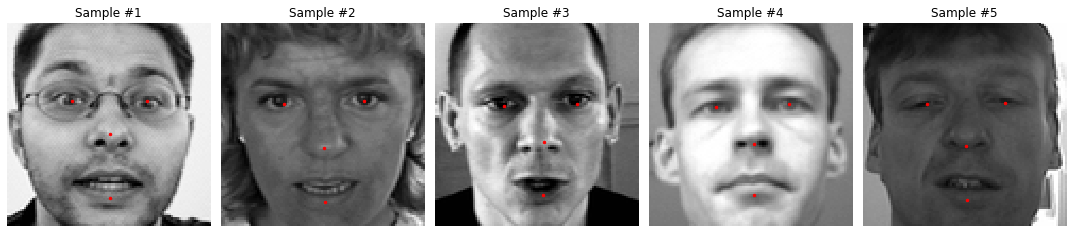

In [67]:
model.load_state_dict(torch.load('L_aug_cnn.pt'))

L_predictions = predict(test_loader, model)

L_columns = L_aug_df.drop('Image', axis=1).columns

view_pred_df(L_columns, test_df, L_predictions)

## S Model

S dataset have 2,155 non-missing samples

In [68]:
# Select S data
S_aug_df = train_data[datasets['S']].dropna()
S_aug_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2155 entries, 0 to 2283
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_inner_corner_x    2155 non-null   float64
 1   left_eye_inner_corner_y    2155 non-null   float64
 2   left_eye_outer_corner_x    2155 non-null   float64
 3   left_eye_outer_corner_y    2155 non-null   float64
 4   right_eye_inner_corner_x   2155 non-null   float64
 5   right_eye_inner_corner_y   2155 non-null   float64
 6   right_eye_outer_corner_x   2155 non-null   float64
 7   right_eye_outer_corner_y   2155 non-null   float64
 8   left_eyebrow_inner_end_x   2155 non-null   float64
 9   left_eyebrow_inner_end_y   2155 non-null   float64
 10  left_eyebrow_outer_end_x   2155 non-null   float64
 11  left_eyebrow_outer_end_y   2155 non-null   float64
 12  right_eyebrow_inner_end_x  2155 non-null   float64
 13  right_eyebrow_inner_end_y  2155 non-null   float

In [69]:
# Define a transform to augment and normalize data
S_aug_tfms = transforms.Compose([RandomHorizontalFlip(p=0.5, dataset='S'),
                                 Normalize(), ToTensor()])

# Create dataset
S_aug_trainset = FaceKeypointsDataset(S_aug_df, transform=S_aug_tfms)


# prepare data loaders
S_aug_train_loader, S_aug_valid_loader = prepare_train_valid_loaders(S_aug_trainset, 
                                                                     valid_size,
                                                                     batch_size)

In [70]:
outputs = len(datasets['S']) - 1
model = CNN(outputs)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [71]:
S_train_losses, S_valid_losses = train(S_aug_train_loader, S_aug_valid_loader, 
                                   model, criterion, optimizer, 
                                   n_epochs=50, saved_model='S_aug_cnn.pt')

Epoch: 1 	Training Loss: 24.191559 	Validation Loss: 5.643933
Validation loss decreased (inf --> 5.643933).  Saving model ...
Epoch: 2 	Training Loss: 6.924649 	Validation Loss: 4.553693
Validation loss decreased (5.643933 --> 4.553693).  Saving model ...
Epoch: 3 	Training Loss: 5.028909 	Validation Loss: 3.690425
Validation loss decreased (4.553693 --> 3.690425).  Saving model ...
Epoch: 4 	Training Loss: 4.207256 	Validation Loss: 3.505177
Validation loss decreased (3.690425 --> 3.505177).  Saving model ...
Epoch: 5 	Training Loss: 3.998116 	Validation Loss: 3.456095
Validation loss decreased (3.505177 --> 3.456095).  Saving model ...
Epoch: 6 	Training Loss: 4.013777 	Validation Loss: 3.436228
Validation loss decreased (3.456095 --> 3.436228).  Saving model ...
Epoch: 7 	Training Loss: 3.900191 	Validation Loss: 3.374692
Validation loss decreased (3.436228 --> 3.374692).  Saving model ...
Epoch: 8 	Training Loss: 3.833868 	Validation Loss: 3.340216
Validation loss decreased (3.3746

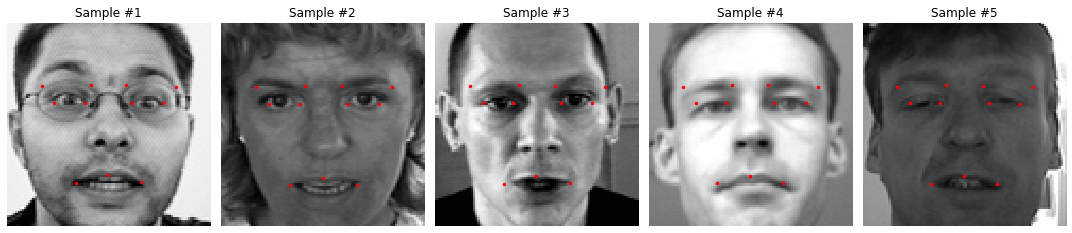

In [73]:
model.load_state_dict(torch.load('S_aug_cnn.pt'))

S_predictions = predict(test_loader, model)

S_columns = S_aug_df.drop('Image', axis=1).columns

view_pred_df(S_columns, test_df, S_predictions)

## Combine L & S model predictions

Now, we combine both predictions and submit.

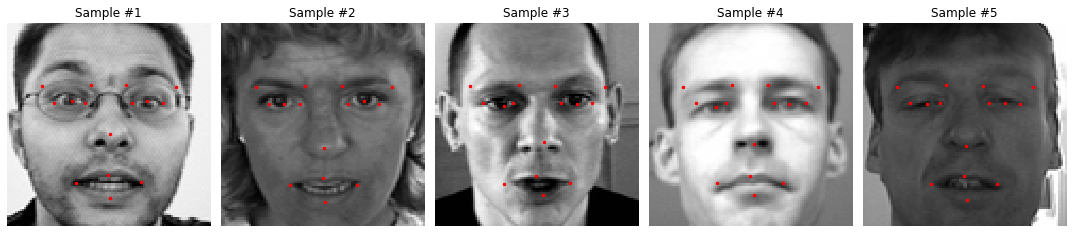

In [74]:
predictions = np.hstack((L_predictions, S_predictions))
columns = list(L_columns) + list(S_columns)
view_pred_df(columns, test_df, predictions)

In [75]:
create_submission(predictions, 
                  pred_file='data/2models_preds.csv', 
                  sub_file='data/2models_submission.csv',
                  columns=columns)

In [84]:
# # Comment out to submit to Kaggle
# !kaggle competitions submit -c facial-keypoints-detection -f data/2models_submission.csv -m "L + S Models"

100%|█████████████████████████████████████████| 629k/629k [00:01<00:00, 364kB/s]
Successfully submitted to Facial Keypoints Detection